# Clustering analysis on 10k PBMC data

In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize, to_categorical
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os

from imp import load_source
from models import *

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## Adversarial Autoencoder: Basic Architecture

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
# Network parameters
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100, 50, 30],
    'layers_dec_dim': [30, 50, 100, 200],
    'layers_dis_dim': [200, 100, 50, 30],
    'batch_size': 35,
    'epochs': 200
}

In [5]:
model = AAE1(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,35,batch size
epochs,200,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          358000      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
____________________________________________________________________________________________

AttributeError: 'NoneType' object has no attribute 'summary'

In [11]:
# Export model graphs

log_dir = '../results/AAE1/PBMC10k/'
os.makedirs('../results/AAE1/PBMC10k/graphs', exist_ok=True)
model.export_graph('../results/AAE1/PBMC10k/graphs')

Model graphs saved.



### Visualize graphs


ENCODER


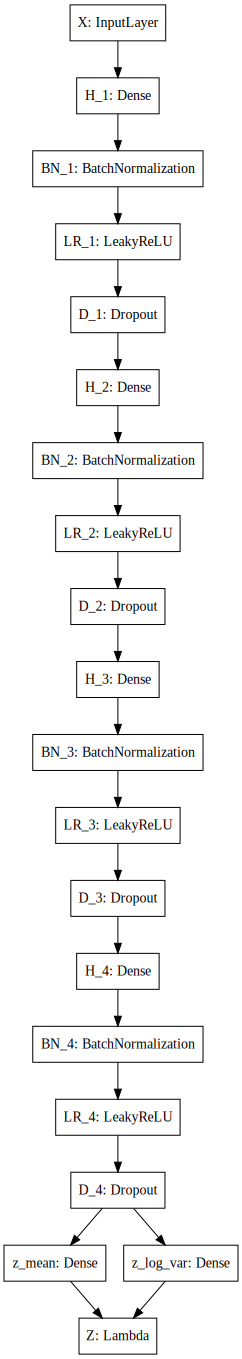

In [12]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


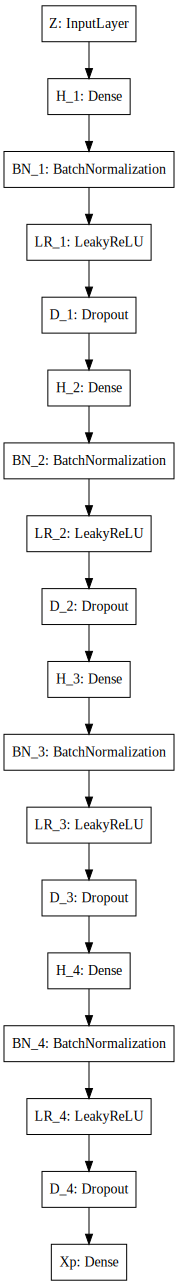

In [13]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


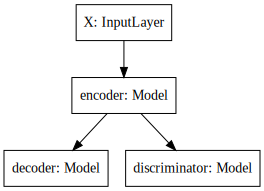

In [14]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


DISCRIMINATOR


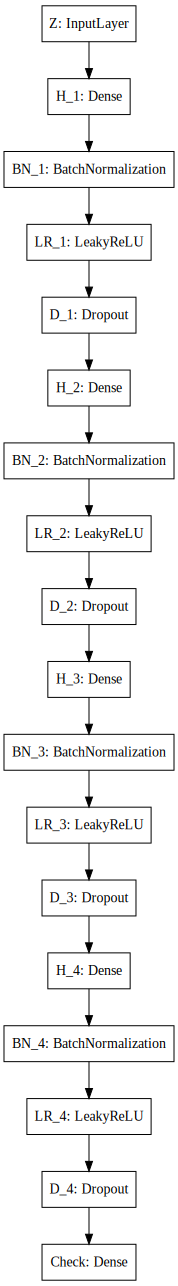

In [15]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 200/200, rec. loss: 1.215449, dis. loss: 0.793606


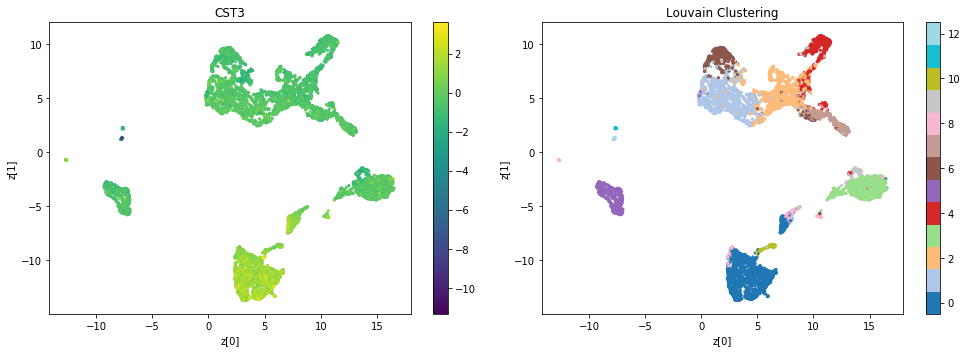

Training completed.
All networks exported in h5 format.
Latent space embedding completed.


In [16]:
# graph=True to show the data points in the 2-D latent space

log_dir = '../results/AAE1/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

GENE = 'CST3' # used only for training visualization 

rec_loss, dis_loss = model.train(graph=True, gene=GENE, log_dir=log_dir)

In [ ]:
#!tensorboard --logdir=../results/AAE1/PBMC10k/

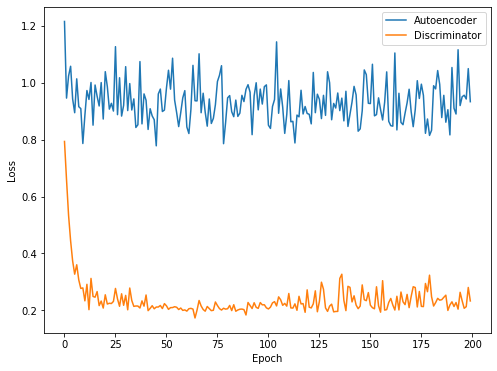

In [25]:
# Plot training loss values
steps = int(len(model.data)/model.batch_size)

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss[::steps])
plt.plot(dis_loss[::steps])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

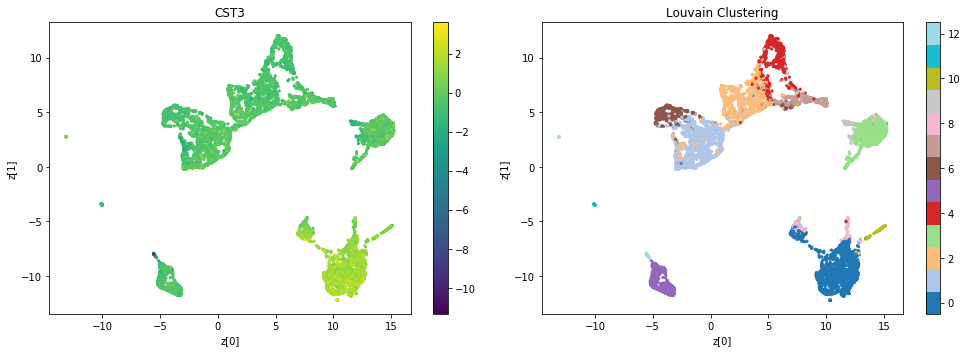

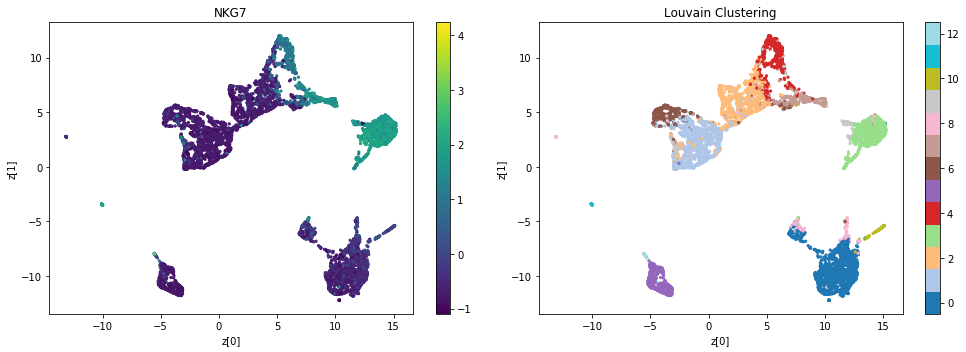

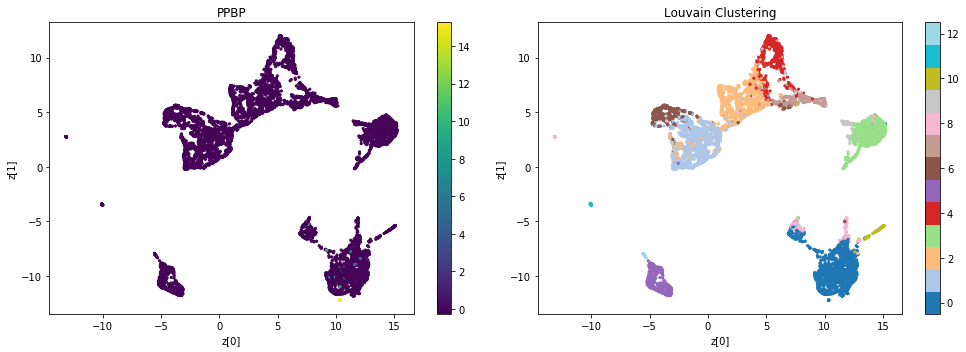

In [18]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

## Unsupervised Adversarial Autoencoder: Setting Number of Clusters

### Build the model

In [4]:
# Network parameters
parameters = {
    'latent_dim': 10,
    'num_clusters': 20,
    'layers_enc_dim': [200, 100, 50, 30],
    'layers_dec_dim': [30, 50, 100, 200],
    'layers_dis_dim': [200, 100, 50, 30],
    'layers_dis_cat_dim': [200, 100, 50, 30],
    'batch_size': 35,
    'epochs': 200,
    'tau': 0.05 # temperature parameter
}

In [5]:
model = AAE2(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,35,batch size
epochs,200,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          358000      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
____________________________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/AAE2/PBMC10k/'
os.makedirs('../results/AAE2/PBMC10k/graphs', exist_ok=True)
model.export_graph('../results/AAE2/PBMC10k/graphs')

Model graphs saved.



### Visualize graphs


ENCODER


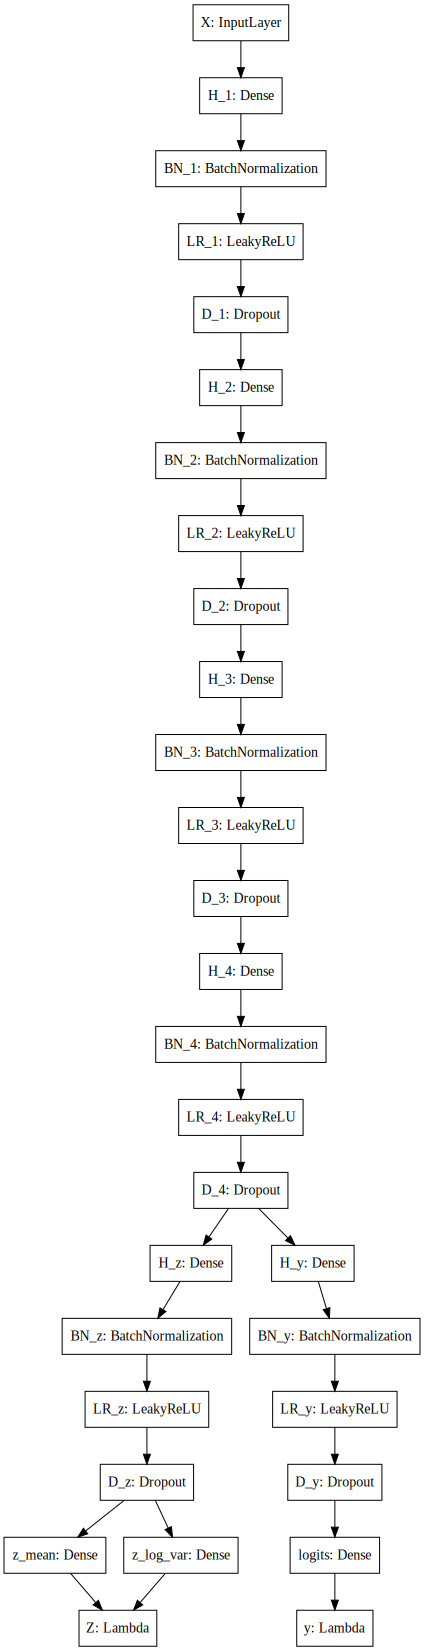

In [12]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


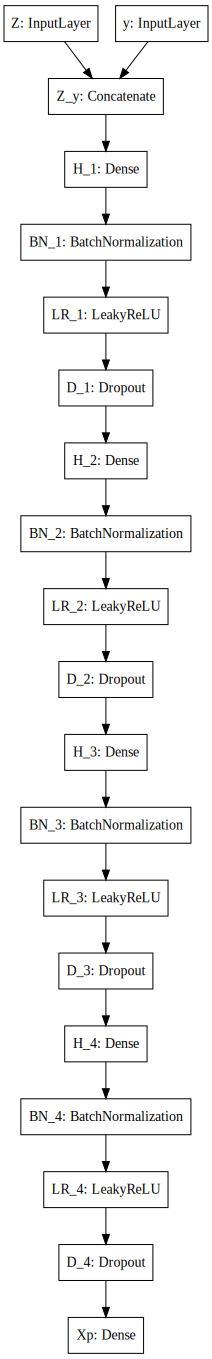

In [13]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


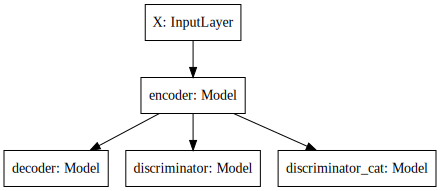

In [14]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


DISCRIMINATOR


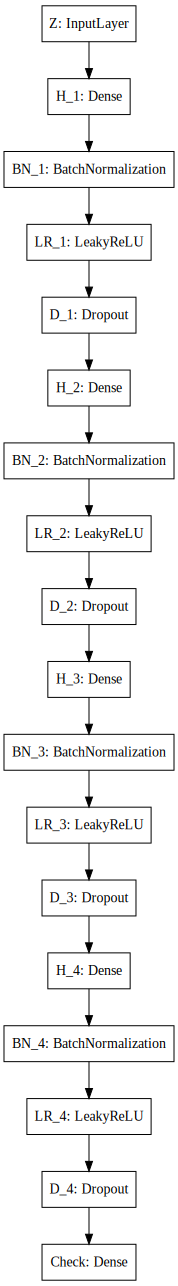

In [15]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))


CATEGORICAL DISCRIMINATOR


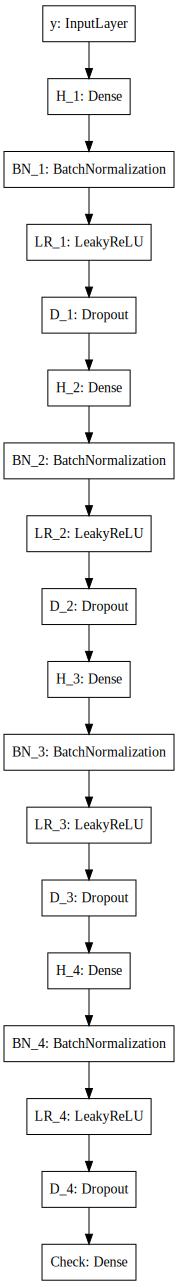

In [16]:
print("\nCATEGORICAL DISCRIMINATOR")
print("=========================")
SVG(model_to_dot(model.discriminator_cat).create(prog='dot', format='svg'))

### Train the model


Epoch 200/200, rec. loss: 1.231240, val. loss: 1.228727, dis. loss: 0.736183, cat. dis. loss: 0.831890


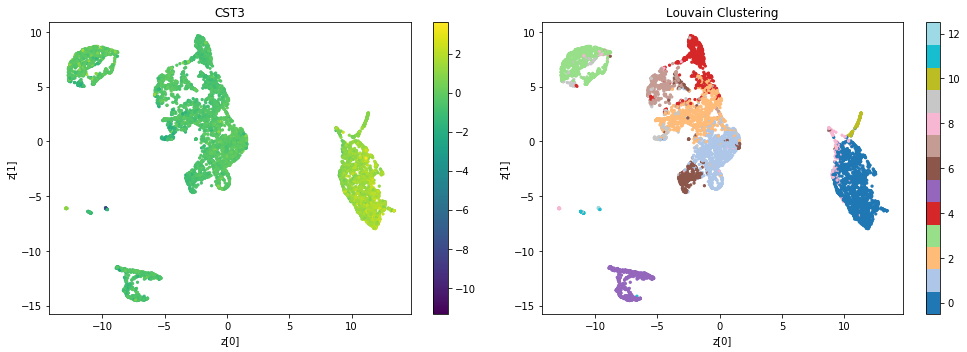

Training completed.
All networks exported in h5 format.
Latent space embedding completed.


In [17]:
# graph=True to show the data points in the 2-D latent space

log_dir = '../results/AAE2/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

GENE = 'CST3' # used only for training visualization 

rec_loss, dis_loss, dis_cat_loss = model.train(graph=True, gene=GENE, log_dir=log_dir)

In [ ]:
#!tensorboard --logdir=../results/AAE5/PBMC10k/

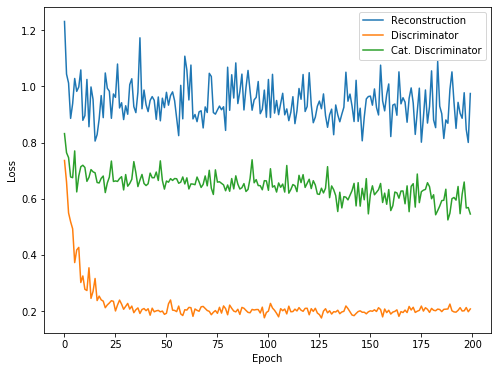

In [20]:
# Plot training loss values
steps = int(len(model.data)/model.batch_size)


plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss[::steps])
plt.plot(dis_loss[::steps])
plt.plot(dis_cat_loss[::steps])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Reconstruction', 'Discriminator', 'Cat. Discriminator'], 
           loc='upper right')
plt.show()

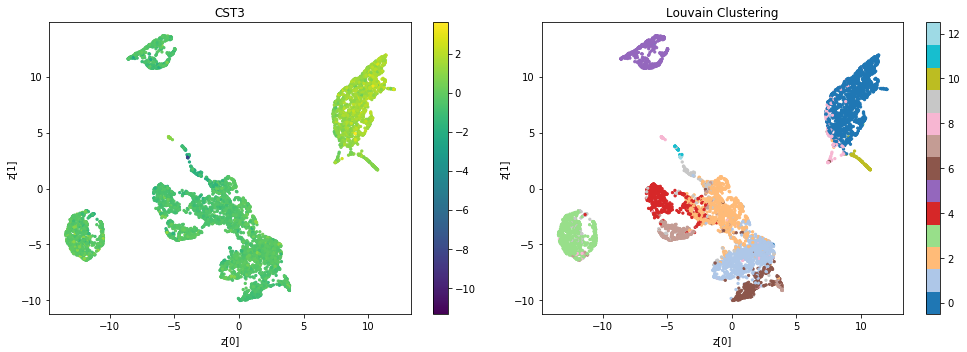

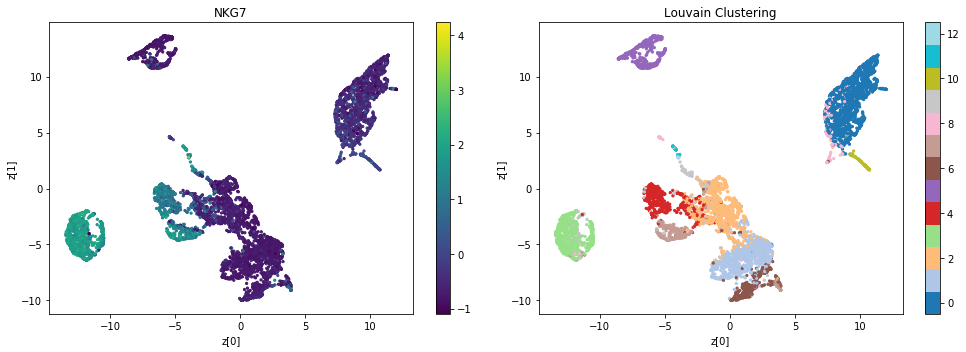

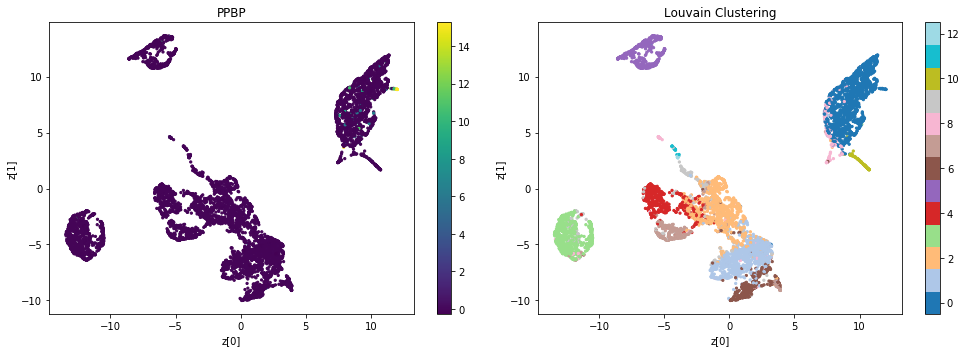

In [19]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

## Variational Autoencoder

<img src="img/variational_autoencoder_model.png" width="800px" style="float:center">

### Build the model

In [4]:
# Network parameters
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100, 50, 30],
    'layers_dec_dim': [30, 50, 100, 200],
    'batch_size': 35,
    'epochs': 500 
}

In [5]:
model = VAE(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,35,batch size
epochs,500,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          358000      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
____________________________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/VAE/PBMC10k/'
os.makedirs('../results/VAE/PBMC10k/graphs', exist_ok=True)
model.export_graph('../results/VAE/PBMC10k/graphs')

Model graphs saved.



### Visualize graphs


ENCODER


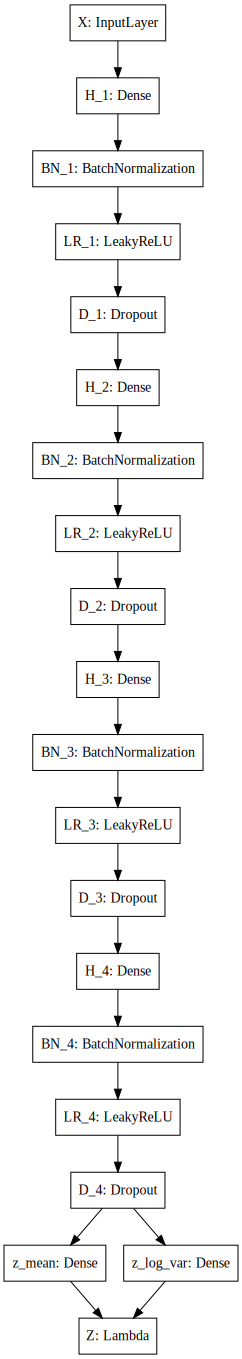

In [12]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


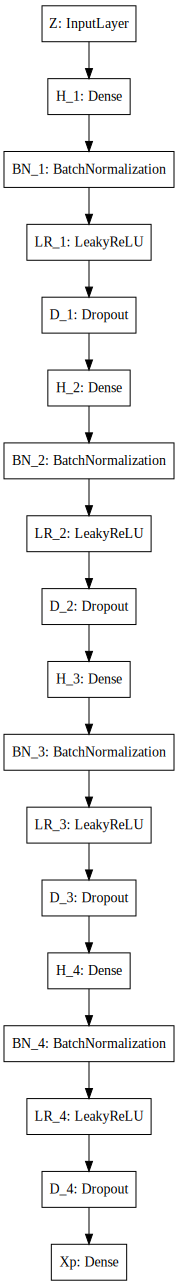

In [13]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


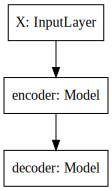

In [14]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))

### Train the model

In [15]:
# Training...

log_dir = '../results/VAE/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

loss, val_loss = model.train(val_split=0.2, log_dir=log_dir)

Start model training...
Train on 6000 samples, validate on 1500 samples
Epoch 1/500
6000/6000 [==============================] - 4s 700us/step - loss: 1982.2156 - val_loss: 1937.6090
Epoch 2/500
6000/6000 [==============================] - 2s 405us/step - loss: 1813.2772 - val_loss: 1833.7297
Epoch 3/500
6000/6000 [==============================] - 2s 407us/step - loss: 1767.3079 - val_loss: 1791.6758
Epoch 4/500
6000/6000 [==============================] - 2s 391us/step - loss: 1743.4979 - val_loss: 1770.3771
Epoch 5/500
6000/6000 [==============================] - 2s 375us/step - loss: 1724.7902 - val_loss: 1747.1921
Epoch 6/500
6000/6000 [==============================] - 2s 379us/step - loss: 1709.9872 - val_loss: 1739.4048
Epoch 7/500
6000/6000 [==============================] - 2s 377us/step - loss: 1703.4485 - val_loss: 1736.6076
Epoch 8/500
6000/6000 [==============================] - 2s 392us/step - loss: 1699.5399 - val_loss: 1734.1277
Epoch 9/500
6000/6000 [=================

Epoch 146/500
6000/6000 [==============================] - 2s 354us/step - loss: 1663.0266 - val_loss: 1704.1882
Epoch 147/500
6000/6000 [==============================] - 2s 359us/step - loss: 1663.3302 - val_loss: 1704.3032
Epoch 148/500
6000/6000 [==============================] - 2s 361us/step - loss: 1663.9598 - val_loss: 1704.2810
Epoch 149/500
6000/6000 [==============================] - 2s 376us/step - loss: 1662.9984 - val_loss: 1704.0149
Epoch 150/500
6000/6000 [==============================] - 2s 363us/step - loss: 1662.6680 - val_loss: 1704.1486
Epoch 151/500
6000/6000 [==============================] - 2s 369us/step - loss: 1663.1140 - val_loss: 1704.0600
Epoch 152/500
6000/6000 [==============================] - 2s 361us/step - loss: 1662.3154 - val_loss: 1703.9722
Epoch 153/500
6000/6000 [==============================] - 2s 364us/step - loss: 1662.4171 - val_loss: 1703.8529
Epoch 154/500
6000/6000 [==============================] - 2s 377us/step - loss: 1662.7653 - val

6000/6000 [==============================] - 2s 342us/step - loss: 1657.3771 - val_loss: 1702.3103
Epoch 291/500
6000/6000 [==============================] - 2s 367us/step - loss: 1657.1371 - val_loss: 1702.2636
Epoch 292/500
6000/6000 [==============================] - 2s 350us/step - loss: 1657.0221 - val_loss: 1702.3393
Epoch 293/500
6000/6000 [==============================] - 2s 338us/step - loss: 1657.2927 - val_loss: 1702.6637
Epoch 294/500
6000/6000 [==============================] - 2s 326us/step - loss: 1657.2572 - val_loss: 1702.3566
Epoch 295/500
6000/6000 [==============================] - 2s 332us/step - loss: 1657.0593 - val_loss: 1702.2690
Epoch 296/500
6000/6000 [==============================] - 2s 380us/step - loss: 1657.0797 - val_loss: 1702.3527
Epoch 297/500
6000/6000 [==============================] - 2s 319us/step - loss: 1657.0000 - val_loss: 1702.4151
Epoch 298/500
6000/6000 [==============================] - 2s 343us/step - loss: 1657.0087 - val_loss: 1702.32

In [ ]:
#!tensorboard --logdir=../results/VAE/PBMC10k/

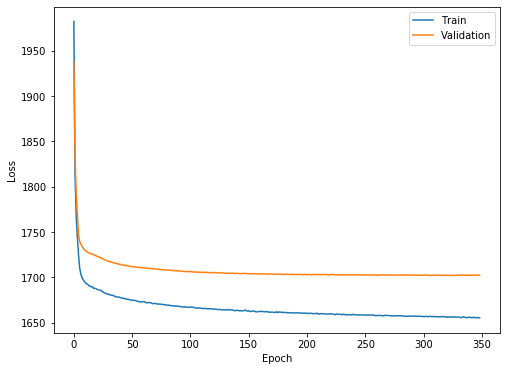

In [16]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

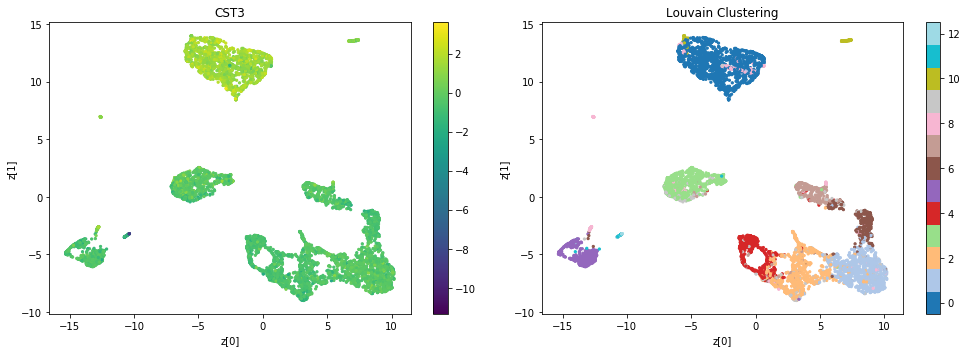

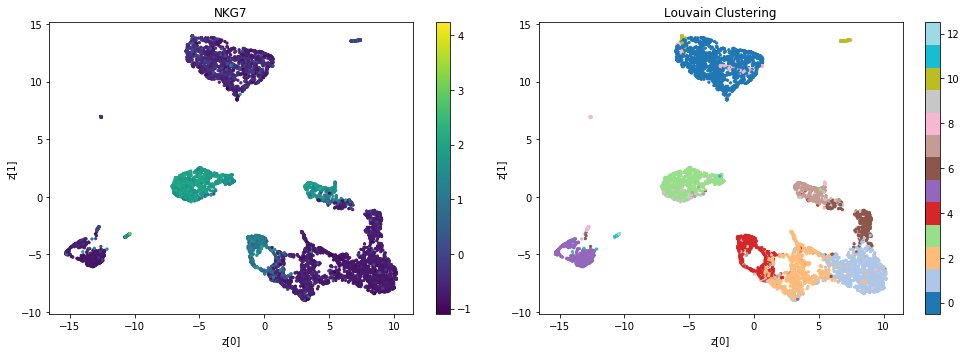

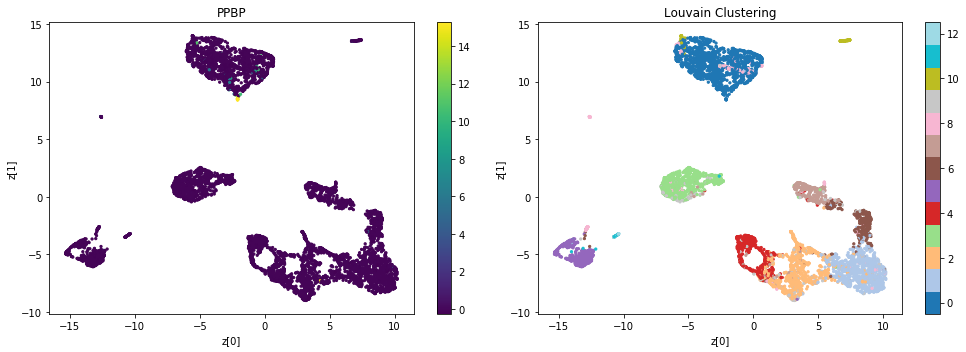

In [17]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)